In [1]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp39-cp39-macosx_10_9_x86_64.whl size=89046 sha256=ef6a6481d81b491718708c7864572b0f2bb8f02e3c5bc5e0fb2cb5277b2471f2
  Stored in directory: /Users/vinoth/Library/Caches/pip/wheels/1f/a1/63/bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
Successfully built fastdtw


In [1]:
import warnings

# Ignore all warnings (not recommended unless you know what you are doing)
warnings.filterwarnings("ignore")
import os

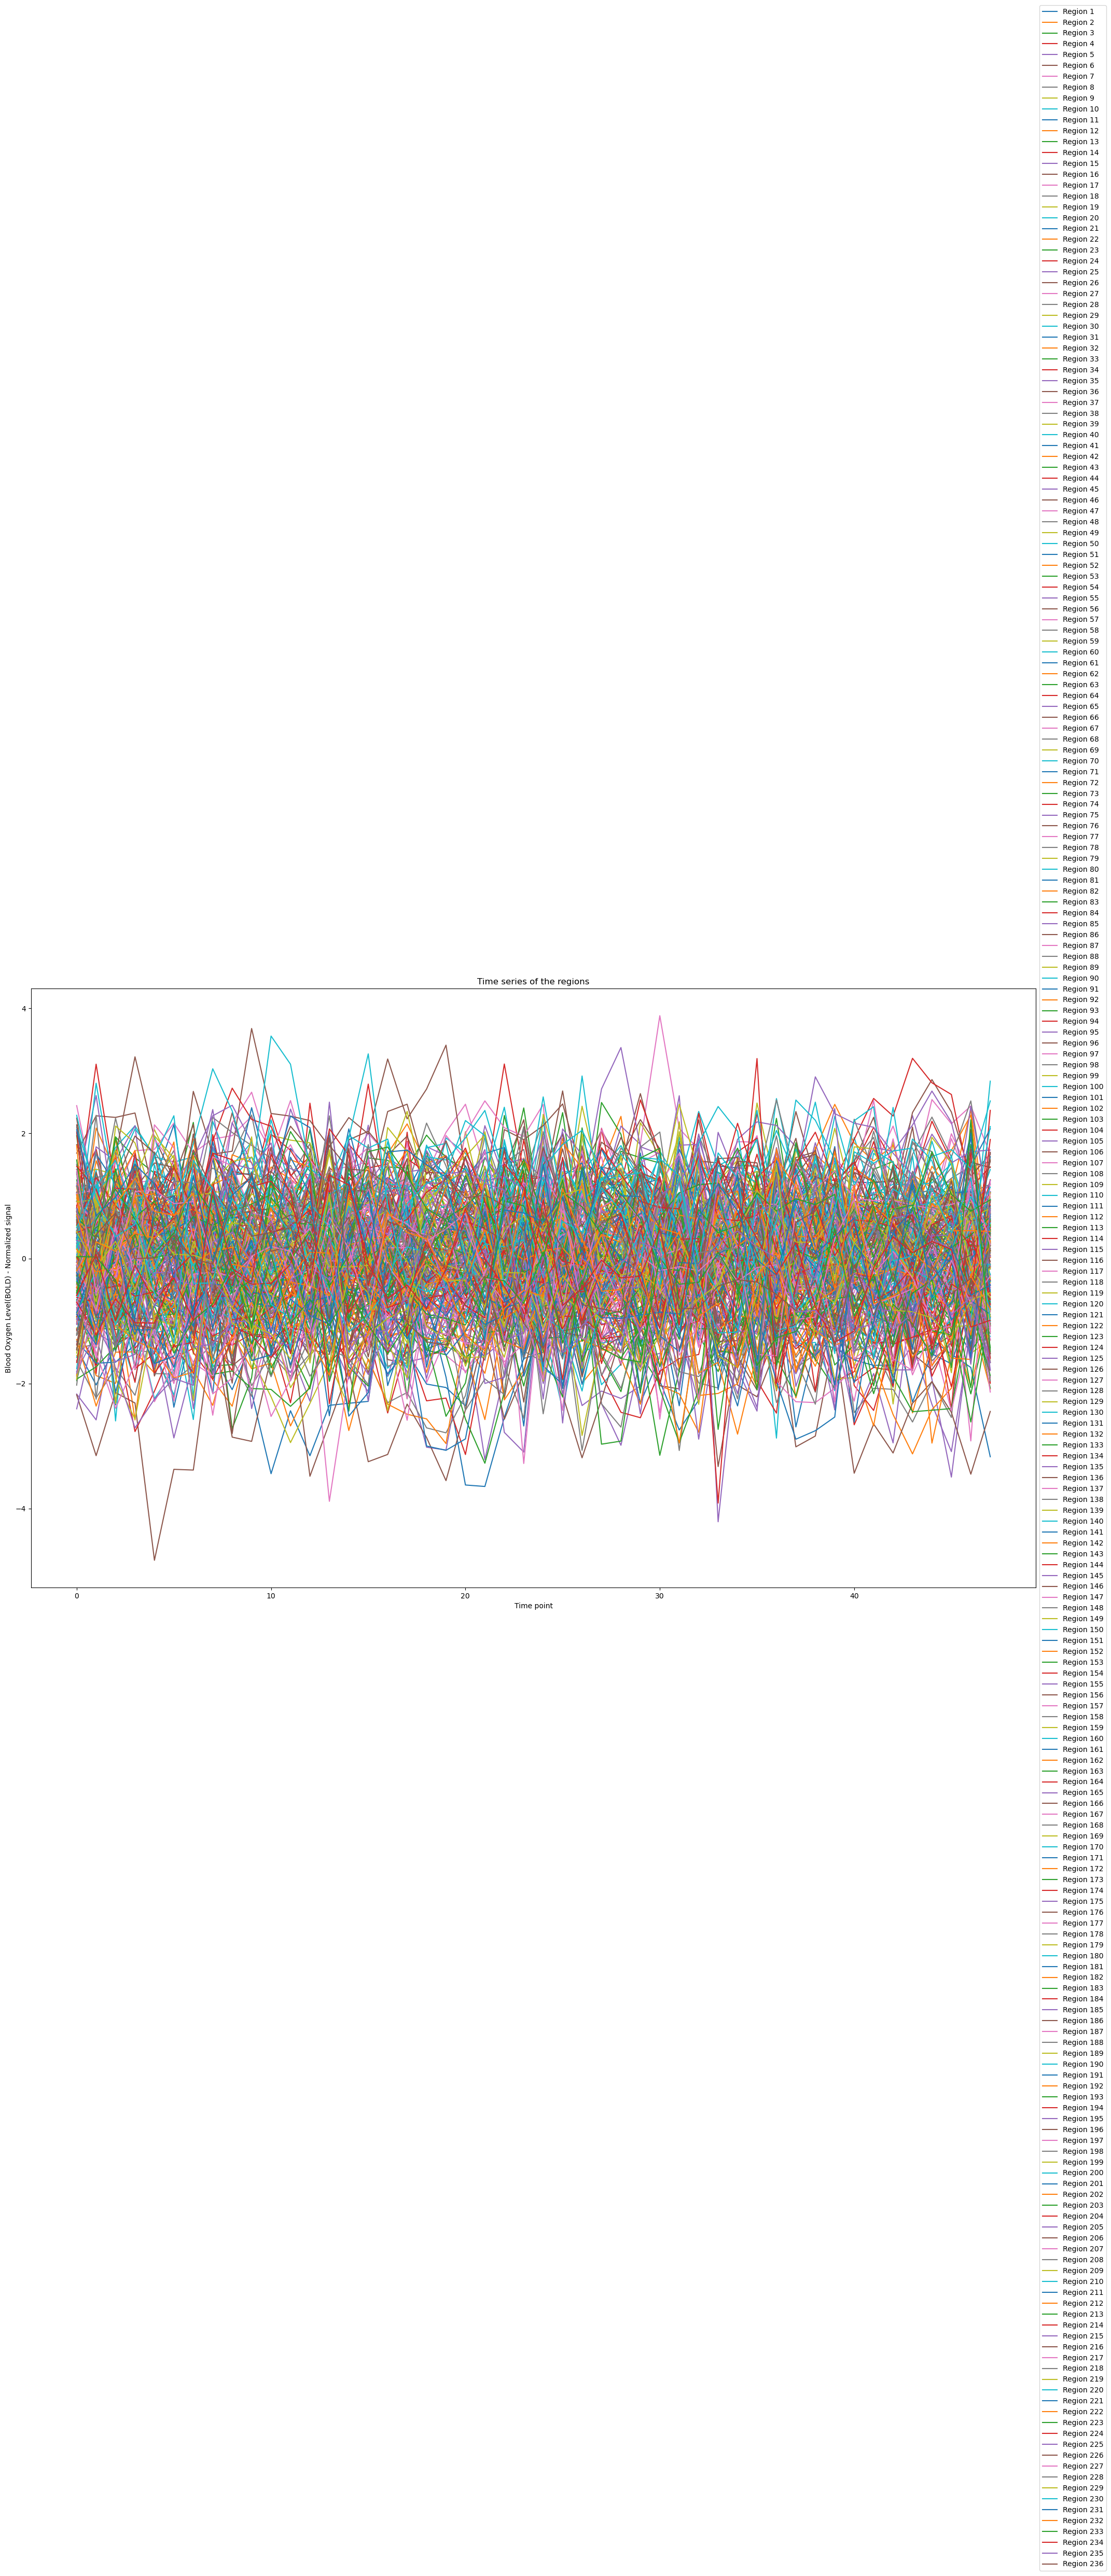

[[1.         0.90071712 0.93141514 ... 0.85880123 0.78182763 0.86656975]
 [0.90071712 1.         0.88703614 ... 0.83403325 0.74566462 0.7938829 ]
 [0.93141514 0.88703614 1.         ... 0.86761242 0.82568414 0.86539031]
 ...
 [0.85880123 0.83403325 0.86761242 ... 1.         0.82470653 0.85341503]
 [0.78182763 0.74566462 0.82568414 ... 0.82470653 1.         0.86365161]
 [0.86656975 0.7938829  0.86539031 ... 0.85341503 0.86365161 1.        ]]


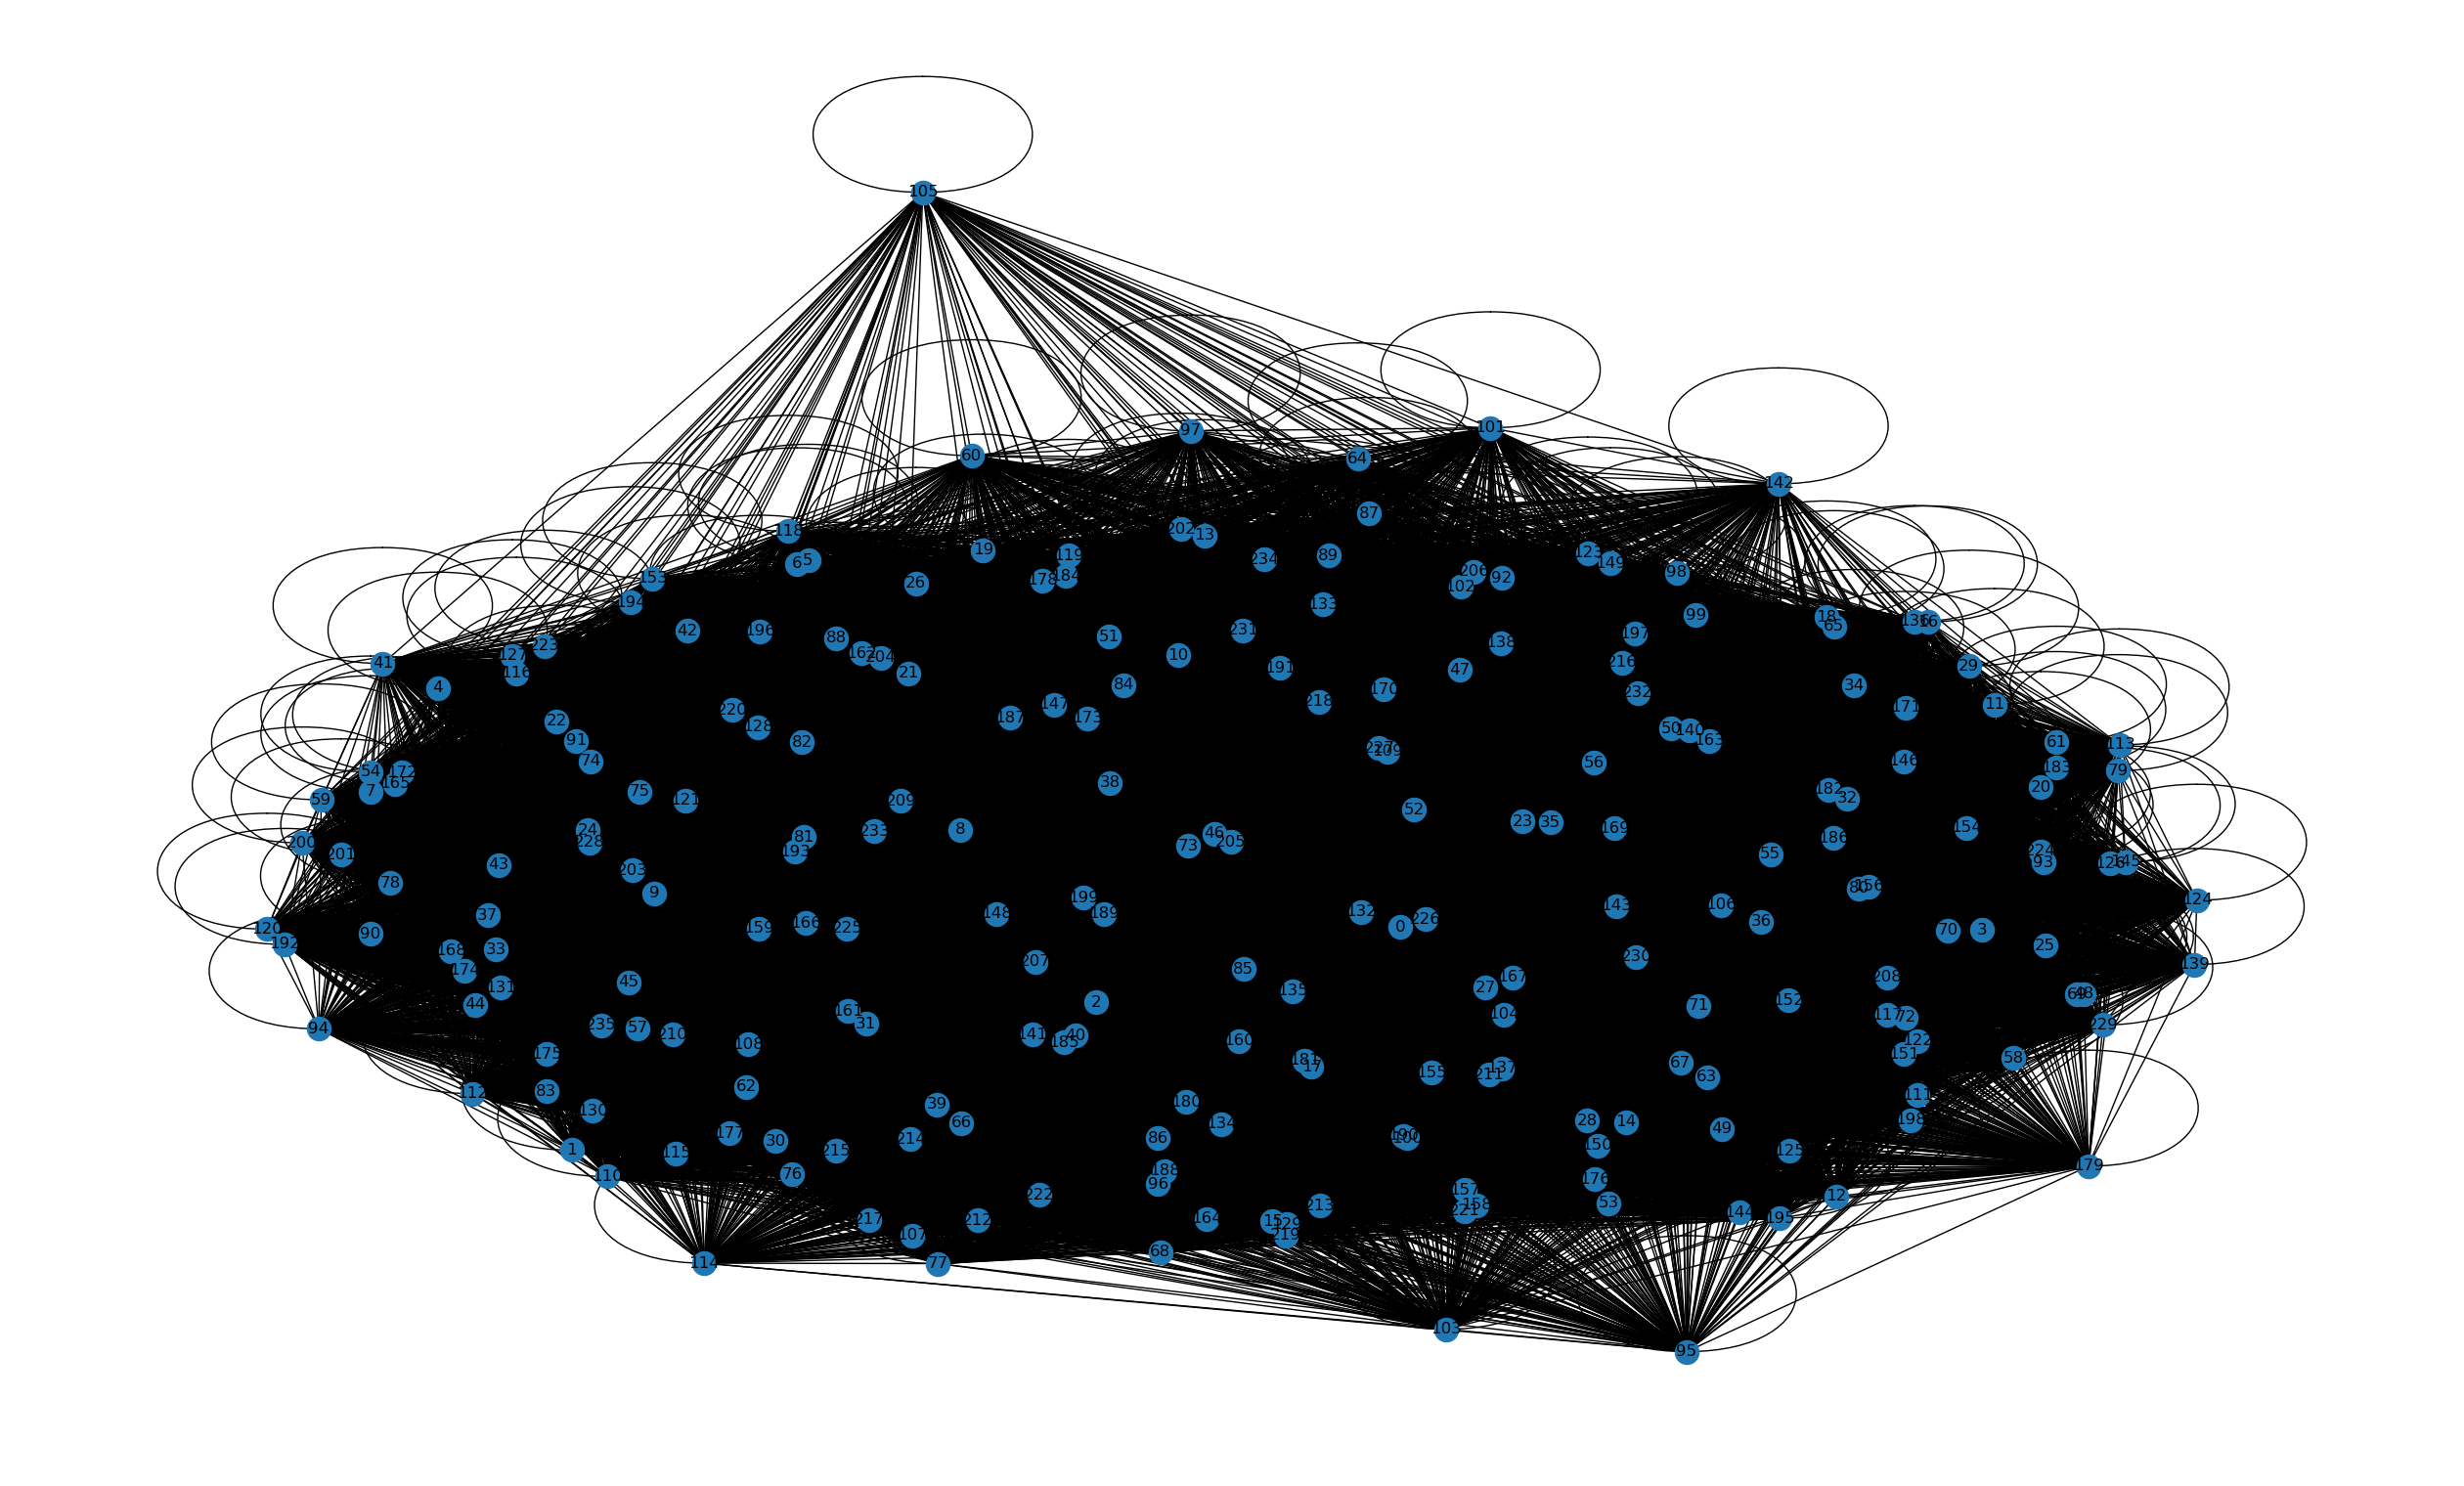

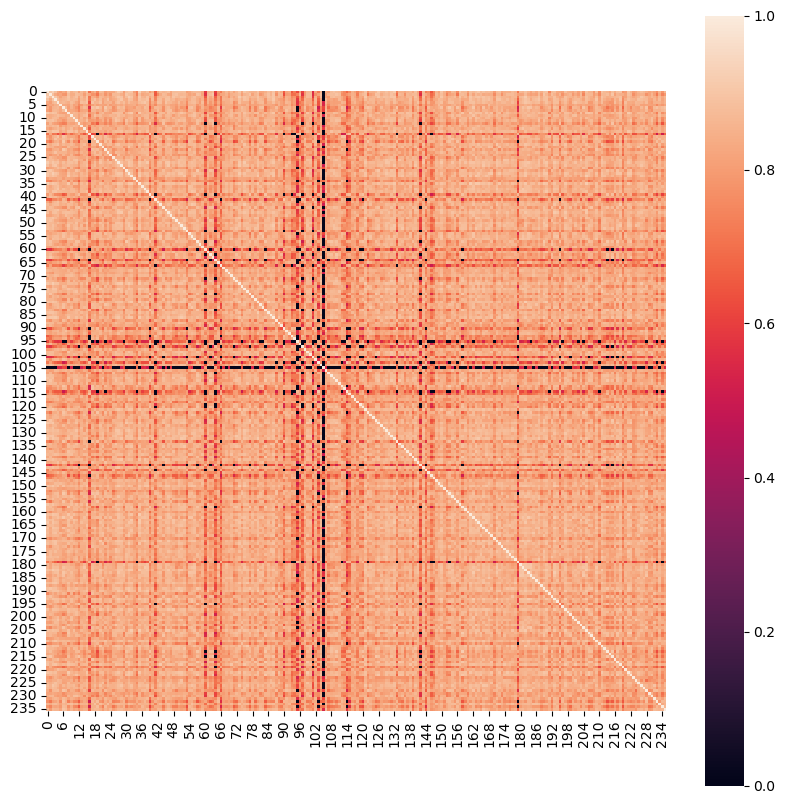

Epoch: 1, Loss: 0.7341948530890725
Epoch: 2, Loss: 0.7111534611745314
Epoch: 3, Loss: 0.695595074783672
Epoch: 4, Loss: 0.6897715303030881
Epoch: 5, Loss: 0.693910227580504
Epoch: 6, Loss: 0.6757465384223245
Epoch: 7, Loss: 0.670145416801626
Epoch: 8, Loss: 0.6739586347883398
Epoch: 9, Loss: 0.6498715552416715
Epoch: 10, Loss: 0.6647307114167647
Epoch: 11, Loss: 0.6528749791058627
Epoch: 12, Loss: 0.6318231279199774
Epoch: 13, Loss: 0.6266914551908319
Epoch: 14, Loss: 0.6242267950014635
Epoch: 15, Loss: 0.6361158327622847
Epoch: 16, Loss: 0.6101783622394908
Epoch: 17, Loss: 0.605411173267798
Epoch: 18, Loss: 0.6020847220312465
Epoch: 19, Loss: 0.5946612601930444
Epoch: 20, Loss: 0.6034564186226238
Epoch: 21, Loss: 0.5827984308654611
Epoch: 22, Loss: 0.5933106351982463
Epoch: 23, Loss: 0.5737693783911791
Epoch: 24, Loss: 0.5902359038591385
Epoch: 25, Loss: 0.5850082026286558
Epoch: 26, Loss: 0.5609214888377623
Epoch: 27, Loss: 0.5833467272194949
Epoch: 28, Loss: 0.5615476139567115
Epoch

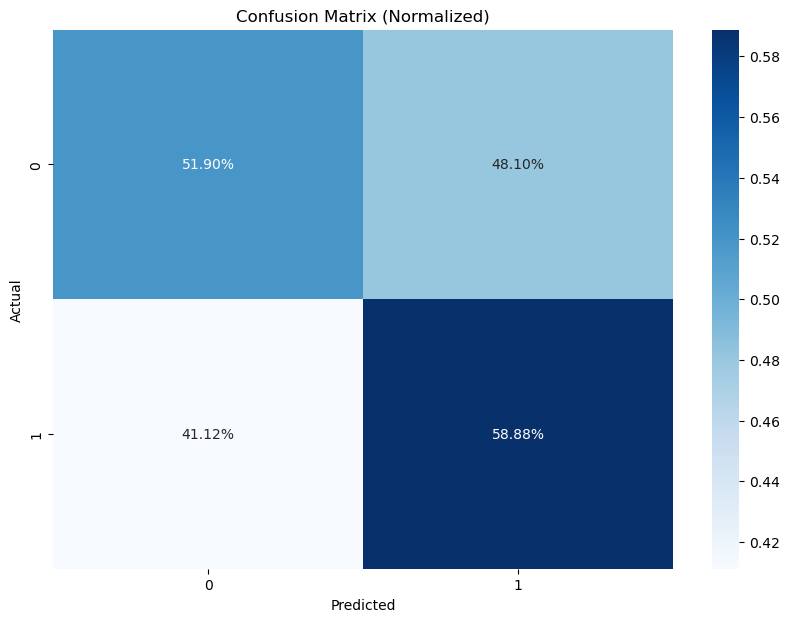

     Actual  Predicted
0       0.0          1
1       1.0          1
2       1.0          0
3       0.0          0
4       1.0          0
..      ...        ...
181     1.0          1
182     1.0          0
183     0.0          0
184     0.0          1
185     1.0          1

[186 rows x 2 columns]
              precision    recall  f1-score   support

Non-Autistic       0.48      0.52      0.50        79
    Autistic       0.62      0.59      0.61       107

    accuracy                           0.56       186
   macro avg       0.55      0.55      0.55       186
weighted avg       0.56      0.56      0.56       186



In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import input_data, datasets
import networkx as nx
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from fastdtw import fastdtw
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.nn import BatchNorm1d, Dropout
import os

# Load the CSV file
csv_file = pd.read_csv(r"/Users/vinoth/PycharmProjects/paper_implementation/Dataset/source/mri_images/ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv")
csv_file['DX_GROUP'].replace({1: 0, 2: 1}, inplace=True)
train_df, test_df = train_test_split(csv_file, test_size=0.2, random_state=42)
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
masker = input_data.NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
mri_dir = r"/Users/vinoth/PycharmProjects/paper_implementation/Dataset/source/mri_images/ABIDE_pcp/cpac/nofilt_noglobal/"

# Placeholder for Graph Neural Network Data
graph_data_list = []

# Data Preprocessing
for idx, row in enumerate(train_df.itertuples()):
    mri_filename = os.path.join(mri_dir, row.FILE_ID + "_func_preproc.nii.gz")
    try:
        mri_img = nib.load(mri_filename)
        time_series = masker.fit_transform(mri_img)
        n_regions, n_time_points = time_series.shape
        distance_matrix = np.zeros((n_regions, n_regions))
        for i in range(n_regions):
            for j in range(i + 1, n_regions):
                distance, _ = fastdtw(time_series[i, :], time_series[j, :])
                distance_matrix[i, j] = distance_matrix[j, i] = distance
        distance_matrix = distance_matrix / distance_matrix.max()
        similarity_matrix = 1 - distance_matrix
        threshold = 0.5
        similarity_matrix[similarity_matrix < threshold] = 0
        G = nx.from_numpy_matrix(similarity_matrix)

        if idx == 0:  # Only for the first iteration
            # Plot the time series for the regions
            plt.figure(figsize=(25, 15))
            for i in range(min(n_regions, time_series.shape[0])):
                plt.plot(time_series[i, :], label=f'Region {i + 1}')
            plt.xlabel('Time point')
            plt.ylabel('Blood Oxygen Level(BOLD) - Normalized signal')
            plt.title('Time series of the regions')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.show()

            print(similarity_matrix)

            # Visualize the graph
            plt.figure(figsize=(25, 15))
            pos = nx.spring_layout(G)
            nx.draw(G, pos, with_labels=True)
            plt.show()

            # Plot the similarity matrix
            plt.figure(figsize=(10, 10))
            sns.heatmap(similarity_matrix, square=True)
            plt.show()

        edge_index = torch.tensor(list(G.edges), dtype=torch.long)
        x = torch.tensor(time_series, dtype=torch.float)
        y = torch.tensor([row.DX_GROUP], dtype=torch.float)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)
        graph_data_list.append(data)
    except FileNotFoundError:
        pass

# Neural Network Model with Regularization, Batch Normalization, and Dropout
class Net(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.bn1 = BatchNorm1d(16)
        self.conv2 = GCNConv(16, 32)
        self.bn2 = BatchNorm1d(32)
        self.fc = torch.nn.Linear(32, num_classes)
        self.dropout = Dropout(0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = graph_data_list[0].num_node_features
num_classes = 2
model = Net(num_features, num_classes).to(device)
loader = DataLoader(graph_data_list, batch_size=32, shuffle=True)

# Hyperparameter Tuning (Example: Adjusting Learning Rate)
learning_rates = [0.01, 0.001, 0.0001]
for lr in learning_rates:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4) # L2 Regularization
    for epoch in range(100):
        total_loss = 0
        model.train()
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out, data.y.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch: {epoch+1}, Loss: {total_loss/len(loader)}')

    # Model Evaluation
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        _, pred = model(data).max(dim=1)
        correct += int((pred == data.y.long()).sum())
    print('Accuracy: {:.4f}'.format(correct/len(loader.dataset)))

# Placeholder for time series data
time_series_list = []
successful_indices = []

# Testing Data Preprocessing
for idx, row in enumerate(test_df.itertuples()):
    mri_filename = os.path.join(mri_dir, row.FILE_ID + "_func_preproc.nii.gz")
    try:
        mri_img = nib.load(mri_filename)
        time_series = masker.fit_transform(mri_img)
        time_series_list.append(time_series)
        successful_indices.append(idx)
    except FileNotFoundError:
        pass

# Placeholder for Graph Neural Network Data for testing
graph_data_test_list = []

for idx, successful_idx in enumerate(successful_indices):
    row = test_df.iloc[successful_idx]
    time_series = time_series_list[idx]
    n_regions = time_series.shape[0]
    distance_matrix = np.zeros((n_regions, n_regions))
    for i in range(n_regions):
        for j in range(i + 1, n_regions):
            distance, _ = fastdtw(time_series[i, :], time_series[j, :])
            distance_matrix[i, j] = distance_matrix[j, i] = distance
    distance_matrix = distance_matrix / distance_matrix.max()
    similarity_matrix = 1 - distance_matrix
    threshold = 0.5
    similarity_matrix[similarity_matrix < threshold] = 0
    G = nx.from_numpy_matrix(similarity_matrix)
    edge_index = torch.tensor(list(G.edges), dtype=torch.long)
    x = torch.tensor(time_series, dtype=torch.float)
    y = torch.tensor([row.DX_GROUP], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)
    graph_data_test_list.append(data)

# Create a data loader for testing data
test_loader = DataLoader(graph_data_test_list, batch_size=32, shuffle=False)

# Testing
model.eval()
correct = 0
all_preds = []
all_labels = []

for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        _, pred = output.max(dim=1)
    all_preds.append(pred.cpu().numpy())
    all_labels.append(data.y.cpu().numpy())
    correct += int((pred == data.y.long()).sum())

accuracy = correct / len(test_loader.dataset)

print(f'Test Accuracy: {accuracy:.4f}')

# Flatten the list of predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2%")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

# Print actual vs predicted
actual_vs_predicted = pd.DataFrame({'Actual': all_labels, 'Predicted': all_preds})
print(actual_vs_predicted)

# Classification report
print(classification_report(all_labels, all_preds, target_names=['Non-Autistic', 'Autistic']))
